In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Input, Lambda, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.losses import mse, BinaryCrossentropy

from convertors import momentums_to_angles

/Users/ilias/.pyenv/versions/running_tensorflow/lib/python3.9/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
%matplotlib inline

In [3]:
pd.options.display.max_columns = 15
np.random.seed(111)
tf.random.set_seed(111)

In [4]:
df = pd.read_csv('Data/monte_carlo_dataset.csv')

dataset = df.to_numpy()[:, 1:]
dataset.shape

(100000, 10)

In [5]:
num_of_samples = dataset.shape[0]
input_shape = dataset.shape[1]
latent_size = 4
EPOCHS = 75
BATCH_SIZE = 1024
num_examples_to_generate = 100000

In [6]:
scaler = MinMaxScaler()
scaler.fit(dataset)

MinMaxScaler()

In [7]:
def normalise(data):
    return scaler.transform(data)

def denormalise(data):
    return scaler.inverse_transform(data)

In [8]:
def generator_model():
    model = Sequential()
    model.add(Input(shape=(latent_size, )))
    model.add(Dense(7, use_bias=False))
    model.add(LeakyReLU())

    model.add(Dense(8, use_bias=False))
    model.add(LeakyReLU())

    model.add(Dense(9, use_bias=False))
    model.add(LeakyReLU())

    model.add(Dense(input_shape, use_bias=False, activation='tanh'))

    return model

In [9]:
def discriminator_model():
    model = Sequential()
    model.add(Input(shape=(input_shape, )))

    model.add(Dense(8))
    model.add(LeakyReLU())

    model.add(Dense(6))
    model.add(LeakyReLU())

    model.add(Dense(3))
    model.add(LeakyReLU())

    model.add(Dense(1))

    return model

In [10]:
generator = generator_model()
generator.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 7)                 28        
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7)                 0         
                                                                 
 dense_1 (Dense)             (None, 8)                 56        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 9)                 72        
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 9)                 0         
                                                                 
 dense_3 (Dense)          

2022-08-05 18:41:55.233618: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-05 18:41:55.233707: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [11]:
discriminator = discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8)                 88        
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 8)                 0         
                                                                 
 dense_5 (Dense)             (None, 6)                 54        
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 6)                 0         
                                                                 
 dense_6 (Dense)             (None, 3)                 21        
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 3)                 0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [12]:
cross_entropy = BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [13]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
seed = tf.random.normal([num_examples_to_generate, latent_size])

In [16]:
# `tf.function` annotation causes the function to be "compiled"
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, latent_size])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [17]:
def generate_sample(model, test_input):
    # `training` set to False means that all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    return predictions

In [18]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for data_batch in dataset:
            train_step(data_batch)

        generate_sample(generator, seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Save models
    generator.save('Model/dgan_generator.hdf5', save_format='tf')
    discriminator.save('Model/dgan_discriminator.hdf5', save_format='tf')

In [19]:
if not os.path.exists('Model/dgan_generator.hdf5') or not os.path.exists('Model/dgan_discriminator.hdf5'):
    train_dataset = tf.data.Dataset.from_tensor_slices(normalise(dataset)).batch(BATCH_SIZE, drop_remainder=True)
    train(train_dataset, EPOCHS)
else:
    generator = load_model('Model/dgan_generator.hdf5')
    discriminator = load_model('Model/dgan_discriminator.hdf5')

2022-08-05 18:41:55.817857: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-05 18:41:55.818009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Time for epoch 1 is 1.2544658184051514 sec
Time for epoch 2 is 0.6952099800109863 sec
Time for epoch 3 is 0.683786153793335 sec
Time for epoch 4 is 0.6686317920684814 sec
Time for epoch 5 is 0.6730649471282959 sec
Time for epoch 6 is 0.6707136631011963 sec
Time for epoch 7 is 0.6503598690032959 sec
Time for epoch 8 is 0.6508300304412842 sec
Time for epoch 9 is 0.6538989543914795 sec
Time for epoch 10 is 0.6533041000366211 sec
Time for epoch 11 is 0.6623878479003906 sec
Time for epoch 12 is 0.65329909324646 sec
Time for epoch 13 is 0.6627788543701172 sec
Time for epoch 14 is 0.7701478004455566 sec
Time for epoch 15 is 0.6689052581787109 sec
Time for epoch 16 is 0.6459100246429443 sec
Time for epoch 17 is 0.6411142349243164 sec
Time for epoch 18 is 0.655430793762207 sec
Time for epoch 19 is 0.6501939296722412 sec
Time for epoch 20 is 0.6488938331604004 sec
Time for epoch 21 is 0.65268874168396 sec
Time for epoch 22 is 0.7893540859222412 sec
Time for epoch 23 is 0.6542558670043945 sec
Tim

### Generate after the final epoch

In [20]:
generated_dataset = denormalise(generate_sample(generator, seed).numpy())

In [21]:
generated_dataset

array([[ 195.43633  , -120.791    ,   74.37954  , ..., -156.0617   ,
         -24.085539 ,   20.244127 ],
       [ 262.34937  , -446.67908  ,   56.419678 , ...,  -35.079403 ,
         -92.13839  ,  105.96839  ],
       [ 183.74527  ,   44.839756 , -174.83434  , ..., -340.74557  ,
         -32.760548 ,   46.98619  ],
       ...,
       [ 204.04268  , -583.4239   ,  112.07555  , ..., -273.0861   ,
         -93.60756  ,   98.95223  ],
       [ 201.35442  , -214.81552  ,    3.8554604, ..., -357.2206   ,
         -33.608223 ,   85.01553  ],
       [ 221.06458  ,   93.25282  ,   18.225992 , ...,  -25.92182  ,
         -21.360912 ,   16.000229 ]], dtype=float32)

#### Create final dataset & export to csv

In [22]:
final_df = pd.DataFrame(generated_dataset, columns=['E1', 'p_x1', 'p_y1', 'p_z1', 'm1',
                                                    'E2', 'p_x2', 'p_y2', 'p_z2', 'm2'])

#### Fix negative values in energy and mass

In [23]:
final_df['E1'] = np.abs(final_df['E1'].to_numpy())
final_df['E2'] = np.abs(final_df['E2'].to_numpy())
final_df['m1'] = np.abs(final_df['m1'].to_numpy())
final_df['m2'] = np.abs(final_df['m2'].to_numpy())

In [24]:
final_df.insert(0, 'event_id', range(1, 1 + len(final_df)))

final_df.to_csv('Data/dgan_dataset.csv', index=False)

print('A sample of our dataset:')
final_df.head(10)

A sample of our dataset:


event_id          E1        p_x1        p_y1        p_z1          m1  \
0         1  195.436325 -120.791000   74.379539  129.969864  100.513824   
1         2  262.349365 -446.679077   56.419678  165.482742   55.667149   
2         3  183.745270   44.839756 -174.834335  121.153603   75.168045   
3         4  227.016708  103.275291 -167.076843  122.275406   80.899239   
4         5  180.426575 -164.951675 -155.346466   45.090889   21.202450   
5         6  165.108231  -90.105965 -184.544006   98.942017   32.019714   
6         7  220.238220 -340.898407  -39.369820  107.106667   24.596706   
7         8  244.994583  -83.734856 -122.020401  155.344818    6.533238   
8         9  203.275955 -515.947754   63.404736  146.284027   27.719368   
9        10  230.123398 -603.128601  132.813614  189.180634   68.081665   

           E2        p_x2        p_y2        p_z2          m2  
0  127.884811  161.386246 -156.061707  -24.085539   20.244127  
1  217.298416 -186.820633  -35.079403  -92.138390  105.968391  
2  152.454437  139.110794 -340.745575  -32.760548   46.986191  
3  160.815094  157.217972 -170.144958  -24.501045   56.911434  
4  140.865036  -71.619812 -106.733643 -121.352684   31.198393  
5  153.140945   19.244143 -312.005219  -83.319824   49.935989  
6  181.763458 -154.353287  -95.503197 -120.694534   82.625252  
7  189.360718    7.222941 -139.241867  -50.941597   97.018127  
8  159.286728 -265.899078 -178.569183 -116.265549   89.816811  
9  179.208817 -332.561615 -216.141434  -87.682877  107.001984

### Plot histograms for energy and azimuthal angle (φ) between VAE generated dataset and Monte Carlo generated dataset
##### Import Monte Carlo dataset

In [25]:
monte_carlo_df = pd.read_csv('Data/monte_carlo_dataset.csv')

#### Plot energy histograms


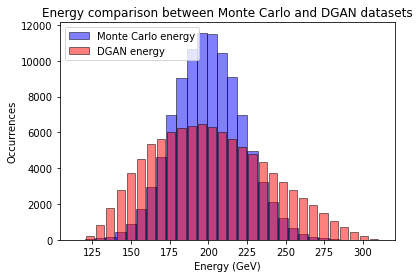

In [26]:
range_min = min([np.min(monte_carlo_df['E1'].to_numpy()), np.min(final_df['E1'].to_numpy())])
range_max = max([np.max(monte_carlo_df['E1'].to_numpy()), np.max(final_df['E1'].to_numpy())])

plt.hist(monte_carlo_df['E1'], range=[range_min, range_max], bins=30, edgecolor='black', color='blue', rwidth=1, alpha=0.5)
plt.hist(final_df['E1'], range=[range_min, range_max], bins=30, edgecolor='black', color='red', rwidth=0.8, alpha=0.5)
plt.title('Energy comparison between Monte Carlo and DGAN datasets')
plt.xlabel('Energy (GeV)')
plt.ylabel('Occurrences')
plt.legend(['Monte Carlo energy', 'DGAN energy'], loc=2)

#### Plot azimuthal angle histograms


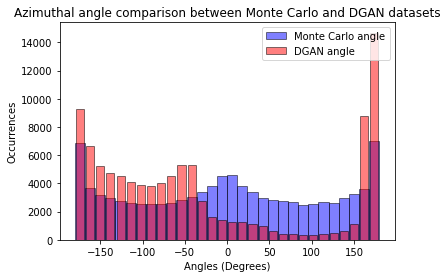

In [27]:
phis_mc, _, _ = momentums_to_angles(monte_carlo_df['p_x1'].to_numpy(), monte_carlo_df['p_y1'].to_numpy(), monte_carlo_df['p_z1'].to_numpy())
phis_vae, _, _ = momentums_to_angles(final_df['p_x1'].to_numpy(), final_df['p_y1'].to_numpy(), final_df['p_z1'].to_numpy())

phis_mc = np.rad2deg(phis_mc)
phis_vae = np.rad2deg(phis_vae)

range_min = min([np.min(phis_mc), np.min(phis_vae)])
range_max = max([np.max(phis_mc), np.max(phis_vae)])

plt.hist(phis_mc, bins=30, range=[range_min, range_max], edgecolor='black', color='blue', alpha=0.5, rwidth=1)
plt.hist(phis_vae, bins=30, range=[range_min, range_max], edgecolor='black', color='red', alpha=0.5, rwidth=0.8)
plt.title('Azimuthal angle comparison between Monte Carlo and DGAN datasets')
plt.xlabel('Angles (Degrees)')
plt.ylabel('Occurrences')
plt.legend(['Monte Carlo angle', 'DGAN angle'], loc=1)

### Plot the relativistic dispersion relation

Text(0, 0.5, 'Momentum (GeV/c)')

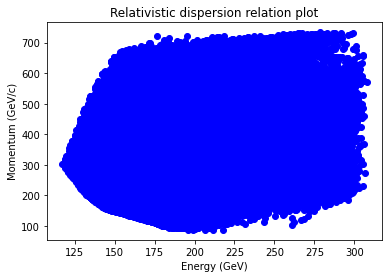

In [28]:
final_df['total_momentum'] = np.sqrt(np.square(final_df['p_x1']) + np.square(final_df['p_y1']) + np.square(final_df['p_z1']))

plt.scatter(final_df['E1'], final_df['total_momentum'], c='blue')
plt.title('Relativistic dispersion relation plot')
plt.xlabel('Energy (GeV)')
plt.ylabel('Momentum (GeV/c)')

### Fit the points in a linear regression to find the best fit

Text(0, 0.5, 'Momentum (GeV/c)')

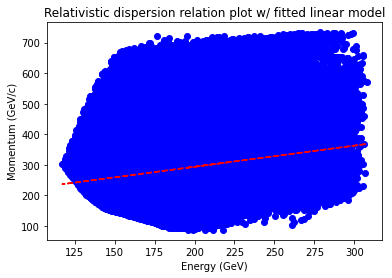

In [29]:
poly1d_fn = np.poly1d(np.polyfit(final_df['E1'], final_df['total_momentum'], 1))

plt.plot(final_df['E1'], final_df['total_momentum'], 'bo', final_df['E1'], poly1d_fn(final_df['E1']), '--r')
plt.title('Relativistic dispersion relation plot w/ fitted linear model')
plt.xlabel('Energy (GeV)')
plt.ylabel('Momentum (GeV/c)')

In [30]:
print(poly1d_fn)

 
0.6915 x + 155.7


In [31]:
a = poly1d_fn[1]
b = 1
c = poly1d_fn[0]

In [32]:
def shortest_distance(xs, ys, a, b, c):
    d = np.abs((a * xs + b * ys + c)) / (np.sqrt(a * a + b * b))
    return d

In [33]:
def rmse(data):
    return np.sqrt(np.sum(np.divide(np.power(data, 2), data.shape[0])))

In [34]:
ds = shortest_distance(final_df['E1'].to_numpy(), final_df['total_momentum'].to_numpy(), a, b, c)
print('Root Mean Squared Error is: ', rmse(ds))

Root Mean Squared Error is:  499.8262893930625
